In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
from itertools import combinations

# General Visualization

We start by doing some visualization of the data to understand the data set better. Part of this was viewing the difference between imports and exports and thus choosing to work only with the export data

#### TODO - bar chart for imports and exports

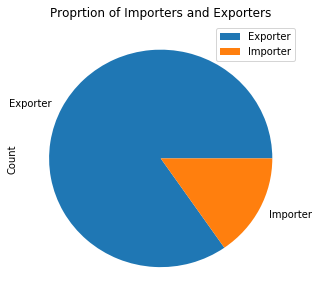

In [89]:
df = pd.read_csv('./data/merchandise_values_annual_dataset.csv', encoding = "ISO-8859-1")
exports_df = df[df['Flow_Description'] == 'Exports']

len_r = len(exports_df.Reporter_description.value_counts())
len_p = len(exports_df.Partner_description.value_counts())


counts_df = pd.DataFrame(data=[['Exporter', len_r], 
                               ['Importer', len_p]], 
                         columns=['Type', 'Count']);
counts_df = counts_df.groupby('Type').sum()
counts_df.plot.pie(y='Count', figsize=(5, 5), title="Proprtion of Importers and Exporters");

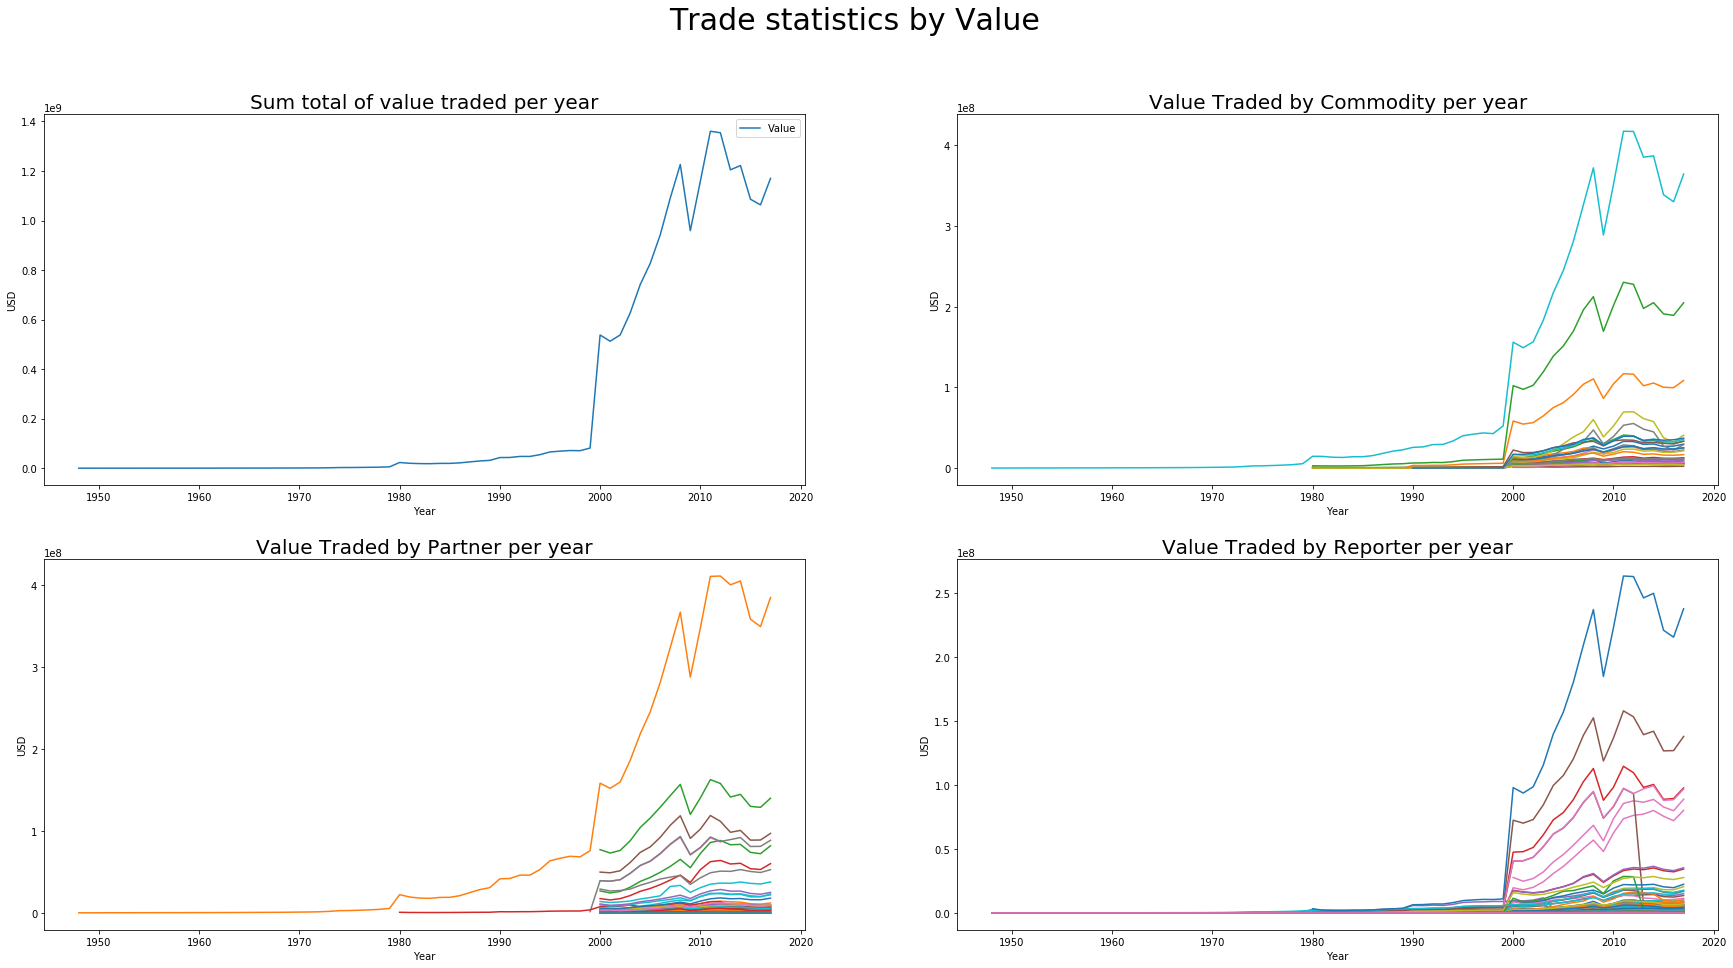

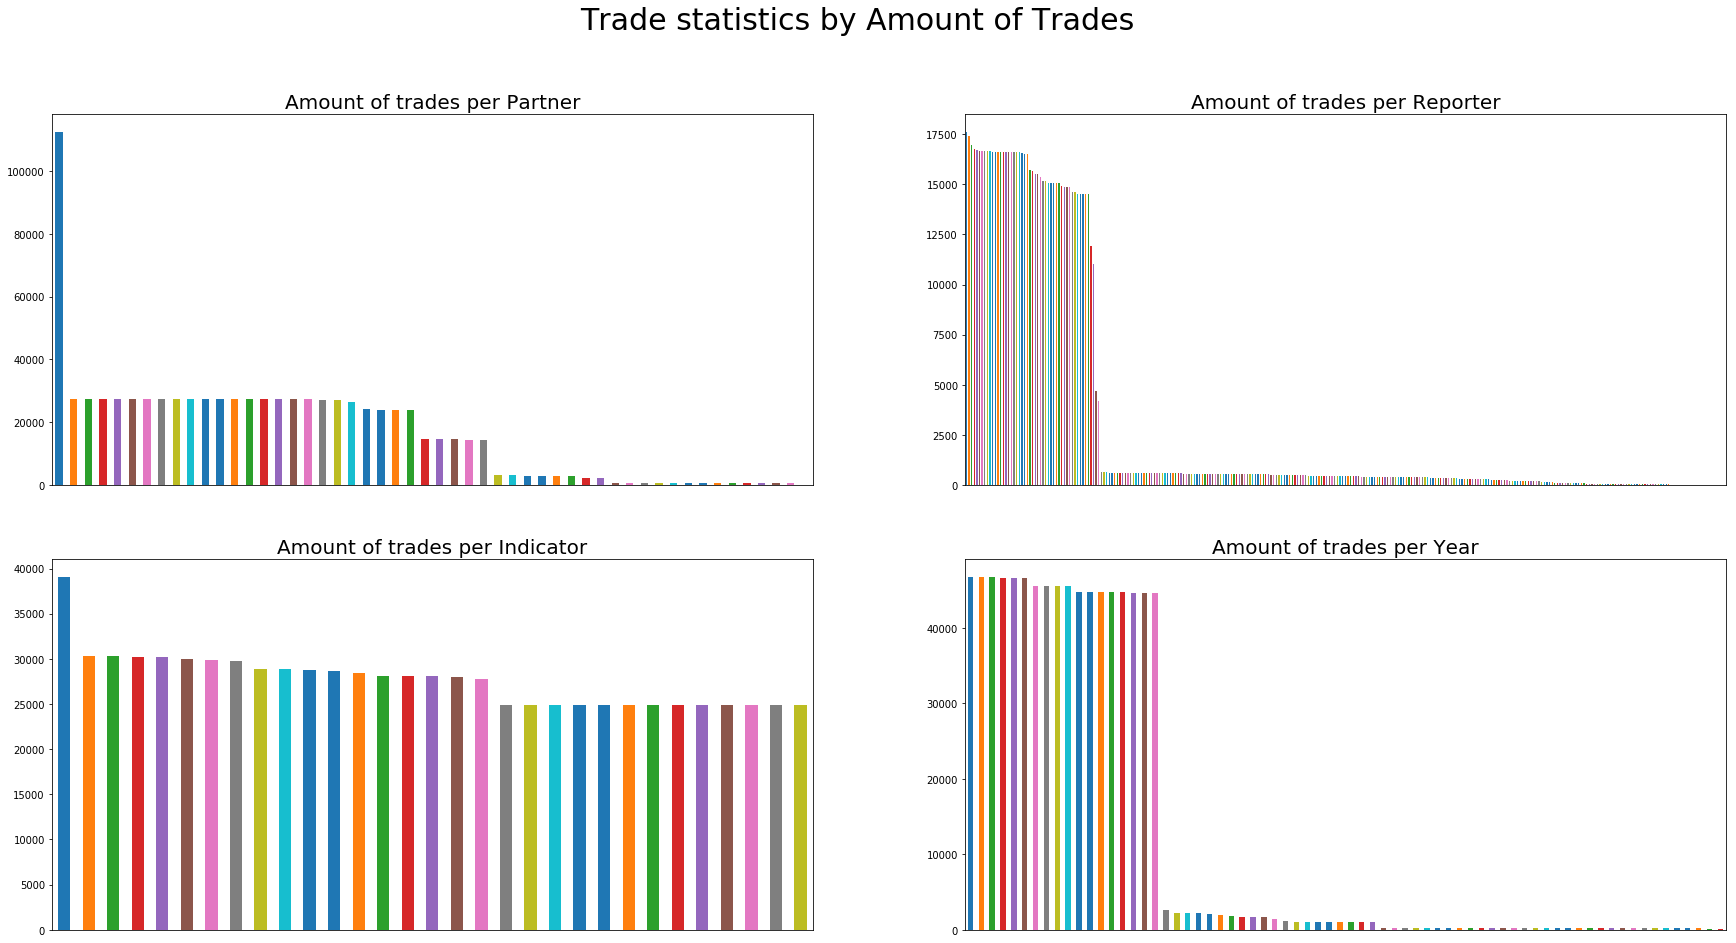

In [92]:
# get data
df = pd.read_csv('./data/merchandise_values_annual_dataset.csv', encoding = "ISO-8859-1")
exports_df = df[df['Flow_Description'] == 'Exports']


def plot_trade_stats_by_value(exports_df):
    # group data for plotting
    grouped_by_year = exports_df.groupby('Year').sum()
    grouped_by_year_merch = exports_df.groupby(['Year', 'Indicator_description']).sum()
    grouped_by_year_partner = exports_df.groupby(['Year', 'Partner_description']).sum()
    grouped_by_year_reporter = exports_df.groupby(['Year', 'Reporter_description']).sum()

    # plot data
    fig, axes = plt.subplots(2, 2, figsize=(30, 15))
    grouped_by_year.plot(ax=axes[0, 0], title="Sum total of value traded per year");
    axes[0, 0].set_ylabel("USD");
    axes[0, 0].title.set_size(20)

    grouped_by_year_merch['Value'].unstack().plot(
        ax=axes[0, 1], legend=False, title='Value Traded by Commodity per year')
    axes[0, 1].set_ylabel("USD");
    axes[0, 1].title.set_size(20)

    grouped_by_year_partner['Value'].unstack().plot(
        ax=axes[1, 0], legend=False, title='Value Traded by Partner per year')
    axes[1, 0].set_ylabel("USD");
    axes[1, 0].title.set_size(20)

    grouped_by_year_reporter['Value'].unstack().plot(
        ax=axes[1, 1], legend=False, title='Value Traded by Reporter per year');
    axes[1, 1].set_ylabel("USD");
    axes[1, 1].title.set_size(20)
    
    plt.suptitle("Trade statistics by Value", fontsize=30);
    plt.show()


def plot_trade_stats_by_amnt_trades(exports_df, sub_title=''):
    fig, axes = plt.subplots(2, 2, figsize=(30, 15))
    
    exports_df['Partner_description'].value_counts().plot(
        ax=axes[0, 0], kind='bar', title='Amount of trades per Partner');
    axes[0, 0].get_xaxis().set_visible(False)
    axes[0, 0].title.set_size(20)

    exports_df['Reporter_description'].value_counts().plot(
        ax=axes[0, 1], kind='bar', title='Amount of trades per Reporter');
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 1].title.set_size(20)

    exports_df['Indicator_description'].value_counts().plot(
        ax=axes[1, 0], kind='bar', title='Amount of trades per Indicator');
    axes[1, 0].get_xaxis().set_visible(False)
    axes[1, 0].title.set_size(20)

    exports_df['Year'].value_counts().plot(
        ax=axes[1, 1], kind='bar', title='Amount of trades per Year');
    axes[1, 1].get_xaxis().set_visible(False)
    axes[1, 1].title.set_size(20)

    plt.suptitle("Trade statistics by Amount of Trades " + sub_title, fontsize=30);
    plt.show()
    

plot_trade_stats_by_value(exports_df)
plot_trade_stats_by_amnt_trades(exports_df)
# plot_trade_stats_by_amnt_trades(exports_df[exports_df['Year'] > 2000], 'After 2000') # didn't seem interesting

### Pie charts for value counts of categorical values

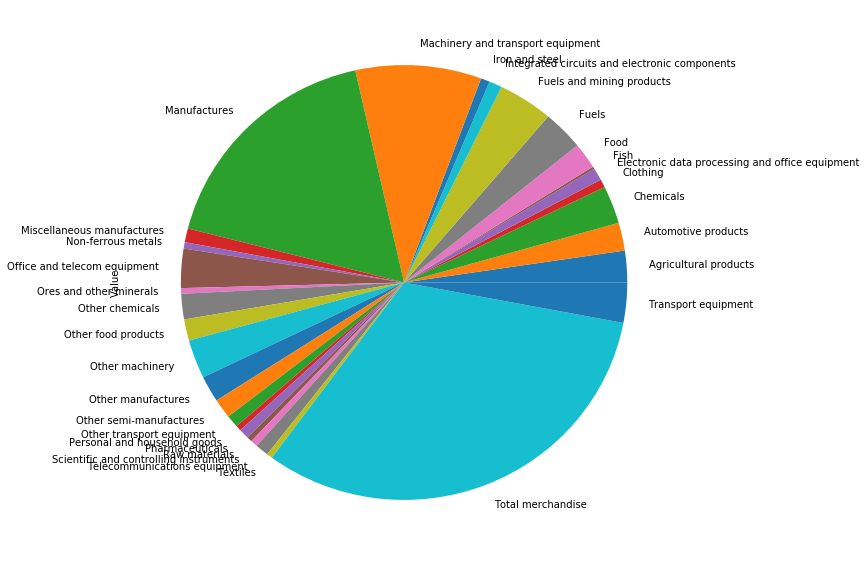

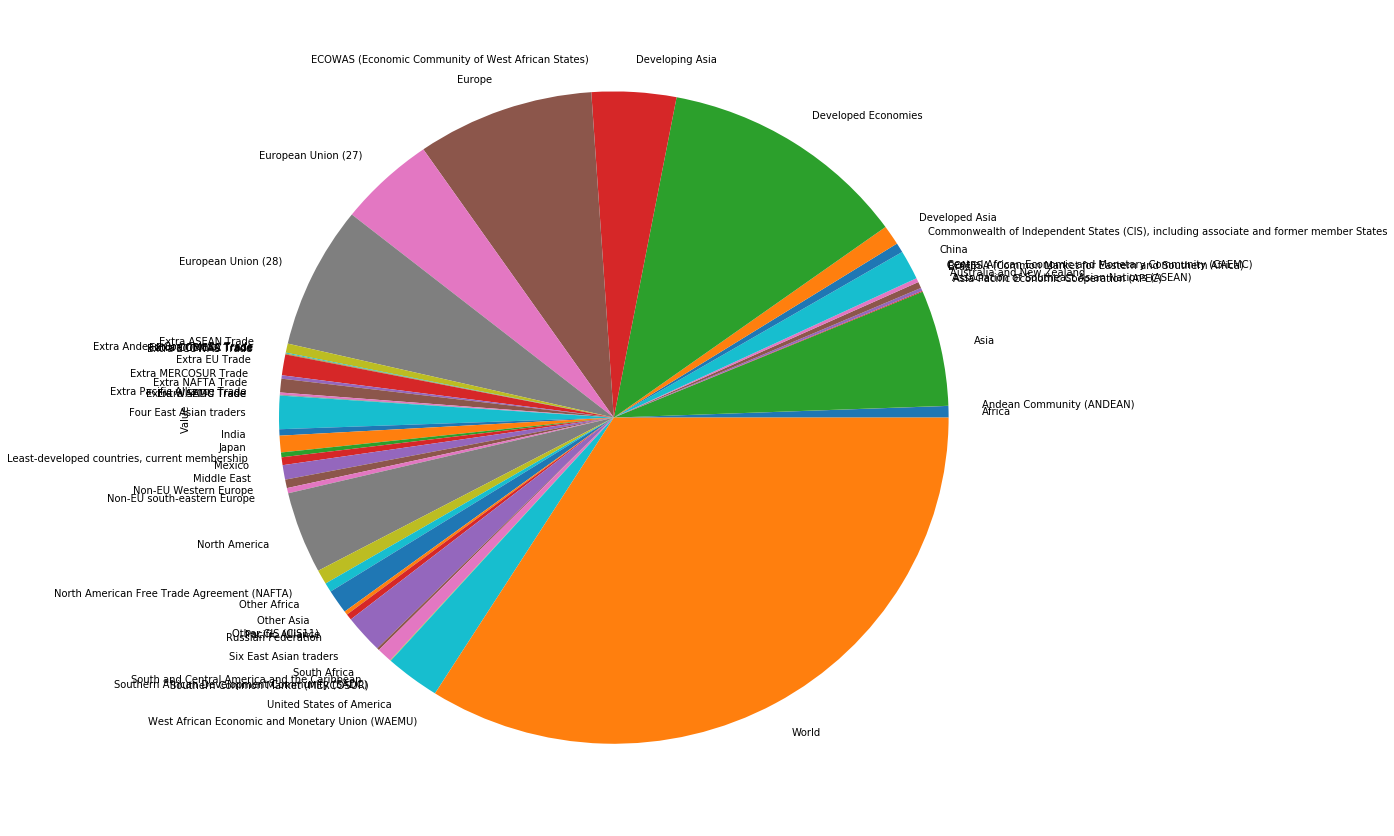

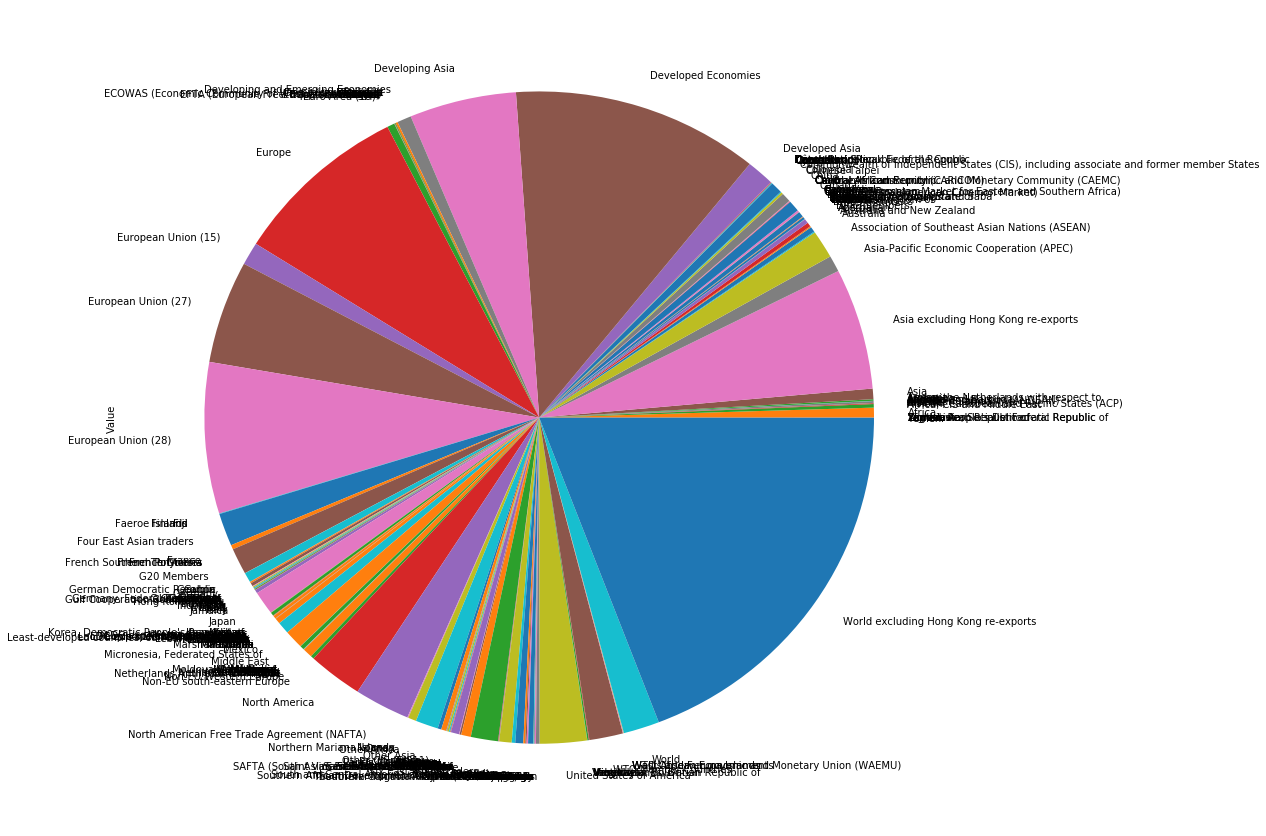

In [85]:
def pie_legend(ax, upp_leg=1.3):
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, upp_leg), ncol=6, fancybox=True, shadow=True)
    

def pie_plots_for_categories(exports_df):

    merch_totals = exports_df.groupby('Indicator_description').sum()
    partner_totals = exports_df.groupby('Partner_description').sum()
    reporter_totals = exports_df.groupby('Reporter_description').sum()
    
    ax_merch = merch_totals.plot.pie(y='Value', figsize=(10, 10), legend=False)
#     pie_legend(ax_merch)
    ax_partner = partner_totals.plot.pie(y='Value', figsize=(15, 15), legend=False)
#     pie_legend(ax_partner)
    ax_rep = reporter_totals.plot.pie(y='Value', figsize=(15, 15), legend=False)
#     pie_legend(ax_rep, 1.7)

    
pie_plots_for_categories(exports_df)

#### Summary

By looking at the amount of trades we can make inferences about the connectivity of the network and the value of goods that are being traded. Some examples include: 
- After the year 2000 the amount of trades per year looks fairly consistent, however after 2010 the value drops significantly. This is therefore likely due to an actual drop in value of goods and not a drop in the amount of trades that are reported. 
- Most of the reporting started after the year 2000, so this is likely the most interesting time period to look at. 
- we see a drop in value around the 2008, likely related to the financial crash
- there has been a somewhat downward trend in value traded in the past 10 years
- value traded by commodity, reporter and partner follow similar patterns
- reporters and partners either trade a lot or a little.  This is likely the split between individual countries and aggregates

Note that we decided to look at sums instead of means because we are more interested in the total goods traded than the average.

# Page Rank and Weighted Page Rank

We wrote code so that the page ranks could be viewed in a few different ways. We can consider page ranks of the network as a whole, per category, over the span of different years or any combination of the previous. Additionally, we have code to compute either weighted or unweighted values. 

##### A note on deadends

We also have code to compute and remove the deadends. In our case, dead ends are nodes which do not export to anyone else. For this datasets all deadends had EXTRA in the name, which likely means it is a category specified by WTO.

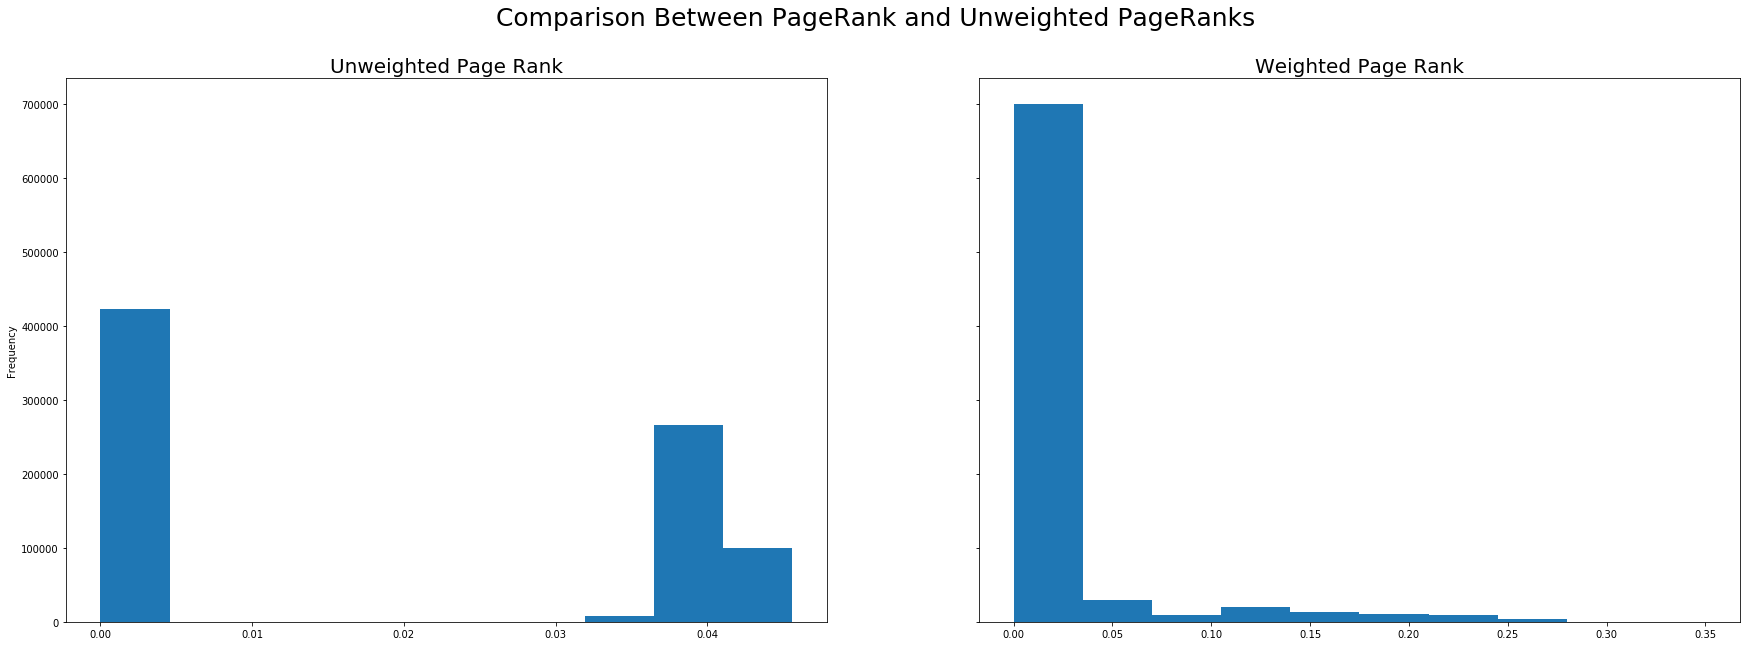

In [64]:
# get data
df = pd.read_csv('./data/merchandise_values_page_ranks_weighted_unweighted.csv')
exports_page_rank_df = df[df['Year'] > 2000]

fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)
exports_page_rank_df.Unweighted_PageRank.plot(ax=axes[0], kind='hist', title='Unweighted Page Rank');
exports_page_rank_df.Weighted_PageRank.plot(ax=axes[1], kind='hist', title='Weighted Page Rank');

axes[0].title.set_size(20)
axes[1].title.set_size(20)
plt.suptitle('Comparison Between PageRank and Unweighted PageRanks', fontsize=25);

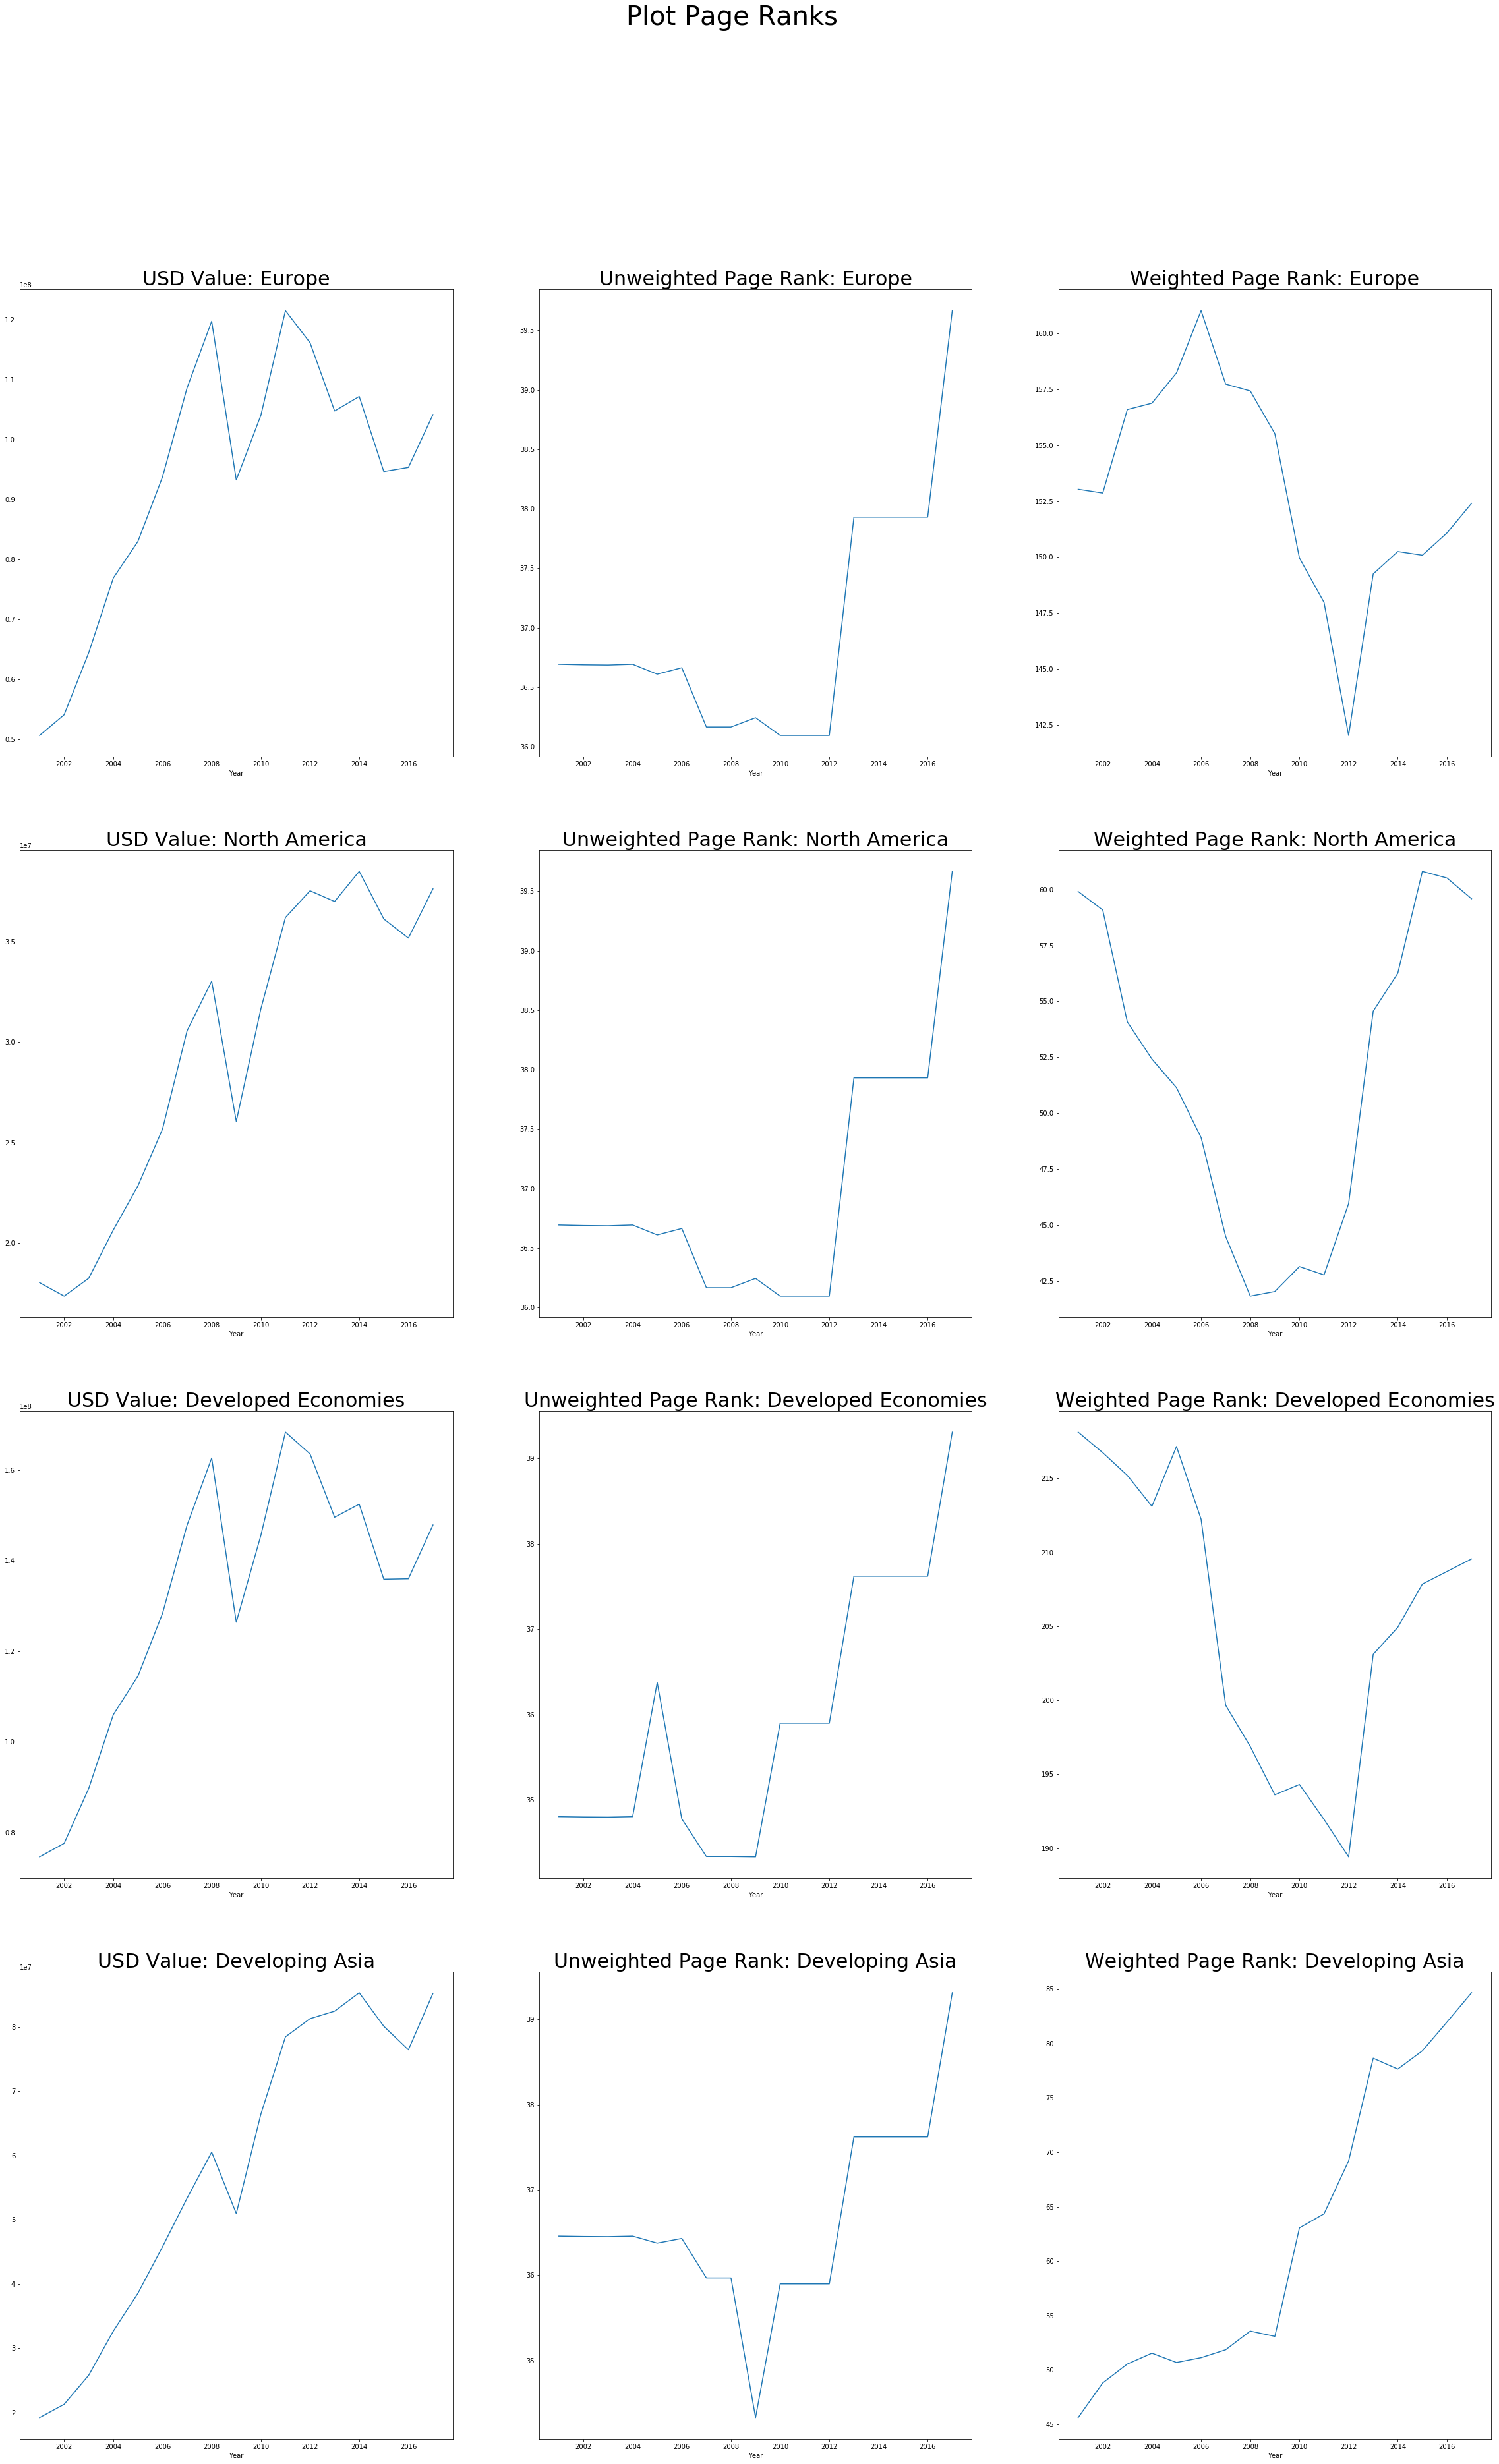

In [34]:
def plot_page_ranks_values(country, df, axes, row, by_commodity=False):
    axes[row, 0].set_title('USD Value: ' + country, fontsize=30)
    axes[row, 1].set_title('Unweighted Page Rank: ' + country, fontsize=30)
    axes[row, 2].set_title('Weighted Page Rank: ' + country, fontsize=30)
    country_exports = df[df['Reporter_description'] == country]
    country_exports['Indicator_description'].value_counts()
    

    if not by_commodity:
        country_exports = country_exports.groupby(['Year']).sum()
        country_exports['Value'].plot(ax=axes[row, 0], legend=False)
        country_exports['Unweighted_PageRank'].plot(ax=axes[row, 1], legend=False)
        country_exports['Weighted_PageRank'].plot(ax=axes[row, 2], legend=False)

    else:
        country_exports = country_exports.groupby(['Year', 'Indicator_description']).sum()
        country_exports['Value'].unstack().plot(ax=axes[row, 0], legend=False)
        country_exports['Unweighted_PageRank'].unstack().plot(ax=axes[row, 1], legend=False)
        country_exports['Weighted_PageRank'].unstack().plot(ax=axes[row, 2], legend=False)
    
    
fig, axes = plt.subplots(4, 3, figsize=(40, 60))
plot_page_ranks_values('Europe', exports_page_rank_df, axes, 0)
# plot_page_ranks_values('Africa', exports_page_rank_df, axes, 0)
plot_page_ranks_values('North America', exports_page_rank_df, axes, 1)
# plot_page_ranks_values('North American Free Trade Agreement (NAFTA)', exports_page_rank_df, axes, 2)
plot_page_ranks_values('Developed Economies', exports_page_rank_df, axes, 2)
plot_page_ranks_values('Developing Asia', exports_page_rank_df, axes, 3)
plt.suptitle("Plot Page Ranks", fontsize=40);
# plt.tight_layout()

### REDUCED PLOTS FOR REPORT

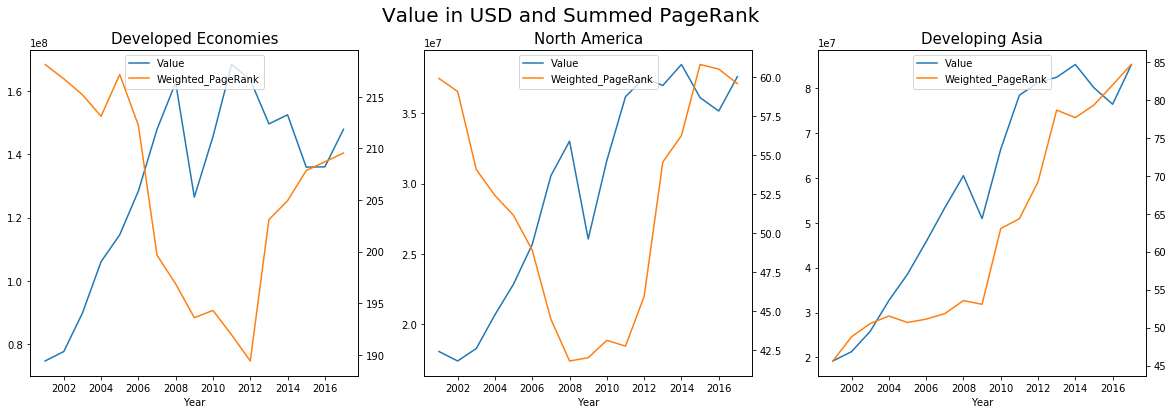

In [124]:
def plot_page_ranks_values(country, df, axes, col, by_commodity=False):
    axes[col].set_title(country, fontsize=15)
    country_exports = df[df['Reporter_description'] == country]
    country_exports['Indicator_description'].value_counts()  

    if not by_commodity:
        country_exports = country_exports.groupby(['Year']).sum()
        country_exports['Value'].plot(ax=axes[col], label='Value')
        country_exports['Weighted_PageRank'].plot(ax=axes[col], secondary_y=True)
    else:
        country_exports = country_exports.groupby(['Year', 'Indicator_description']).sum()
        country_exports['Value'].unstack().plot(ax=axes[col], label='Value')
        country_exports['Weighted_PageRank'].unstack().plot(ax=axes[col])
        
    lines = axes[col].get_lines() + axes[col].right_ax.get_lines()
    axes[col].legend(lines, [l.get_label() for l in lines], loc='upper center')

        
# ASIA BY COMMODITY    
# df_asia = df[df['Reporter_description'] == 'Developing Asia']
# df_asia = df_asia.groupby(['Year', 'Indicator_description']).mean()
# ax = df_asia['Weighted_PageRank'].unstack().plot(
#     figsize=(10, 7), 
#     legend=False, 
#     title='Weighted PageRank in Developing Asia by Commodity');

# ax.title.set_size(15)
# ax.set_ylabel("Mean PageRank");
# plt.show()


# COMPARISON OF PAGE RANKS
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plot_page_ranks_values('Developed Economies', exports_page_rank_df, axes, 0)
plot_page_ranks_values('North America', exports_page_rank_df, axes, 1)
plot_page_ranks_values('Developing Asia', exports_page_rank_df, axes, 2)
plt.suptitle("Value in USD and Summed PageRank", fontsize=20);
# plt.tight_layout()

# df_largest = df_asia.nlargest(20, 'Weighted_PageRank')
# df_largest

In [125]:
# df_max = df.groupby(['Year', 'Reporter_description']).max()
# df_max
df = pd.read_csv('./data/merchandise_values_page_ranks_weighted_unweighted.csv')

df_grouped = df.groupby(['Year', 'Reporter_description']).sum()
df_diff = (df_grouped.loc[2007] - df_grouped.loc[2008])
df_diff.nsmallest(200, 'Weighted_PageRank')

,Unnamed: 0,Value,Weighted_PageRank,Unweighted_PageRank
Reporter_description,,,,
"Commonwealth of Independent States (CIS), including associate and former member States",-864901,-2.502104e+06,-1.722493e+00,0.0
Developing Asia,-864901,-7.162192e+06,-1.715596e+00,0.0
Middle East,-864901,-3.796656e+06,-1.155371e+00,0.0
Russian Federation,-865224,-1.745955e+06,-1.035428e+00,0.0
Other Africa,-864901,-1.713866e+06,-9.398297e-01,0.0
Africa,-864901,-1.893980e+06,-9.171789e-01,0.0
South and Central America and the Caribbean,-864901,-1.362765e+06,-7.993727e-01,0.0
Other Asia,-864901,-1.468772e+06,-7.901552e-01,0.0
Other CIS (CIS11),-864901,-9.155795e+05,-7.068159e-01,0.0


# Frequent Items and Association Rules

In [94]:
df = pd.read_csv('./data/merchandise_values_annual_dataset.csv', encoding="ISO-8859-1")
df_exports = df[(df['Flow_Description'] == 'Exports') & (df['Year'] > 2000)]

def items_in_set(items, set):
    for i in items:
        if i not in set:
            return False
    return True


def subsets(s, num):
    for cardinality in range(num):
        yield from combinations(s, cardinality)

def find_supports(items_dict, candidate_pairs, frequent_threshold, num, frequent):
    frequent_supports = []
    infrequent_supports = []

    items = set()

    for key, item in candidate_pairs.items():
        for i in item:
            items.add(i)

    # print(items)
    for i in subsets(items, num):
        support = 0
        for item, item_set in items_dict.items():
            if items_in_set(i, item_set):
                support += 1
        support = support/len(items_dict)
        support_item_tuple = (i, support)
        if frequent:
            if support >= frequent_threshold:
                frequent_supports.append(support_item_tuple)
        else:
            if support <= frequent_threshold:
                frequent_supports.append(support_item_tuple)

        if support <= 0.05:
            infrequent_supports.append(support_item_tuple)

#     print('amnt frequent', len(frequent_supports))
    return frequent_supports, infrequent_supports

def create_itemsets(data):
    items_dict = {}
    for reporter, item in data:
        items_list = items_dict.get(reporter)
        if items_list is None:
            items_dict[reporter] = {item}
        else:
            items_list.add(item)
            items_dict[reporter] = items_list
    return items_dict

def create_itemsets_with_partner(data):
    items_dict = {}
    for reporter, item, partner in data:
        items_list = items_dict.get(reporter)
        if items_list is None:
            items_dict[reporter] = {(item, partner)}
        else:
            items_list.add((item, partner))
            items_dict[reporter] = items_list
    return items_dict

def find_frequent_itemsets(items_dict, candidate_pairs, threshold, setsize, frequent):
    for i in range(setsize):
        frequent_supports, _ = find_supports(items_dict, candidate_pairs, threshold, i+2, frequent)
        frequent_sets = {}
        c_num = 0
        candidate_pairs = {}
        for (item), support in frequent_supports[1:]:
            if len(item) == setsize:
                ordered_item = list(item)
                ordered_item.sort()
                frequent_sets[tuple(ordered_item)] = support
            candidate_pairs[c_num] = item
            c_num += 1
    return frequent_sets

def create_itemsets_specify_partner(use_partner, data_exports, set_order):
    if use_partner:
        # Create items including partner descriptions
        x = data_exports.groupby(['Reporter_description', 'Indicator_description', 'Partner_description']).sum()
        x_index = x.index
        items_dict = create_itemsets_with_partner(list(x.index))
    else:
        # Create items just based on category
        x = data_exports.groupby(set_order).sum()
        x_index = x.index
        items_dict = create_itemsets(list(x.index))
    return items_dict

def find_association_rules(items_dict, threshold, setsize, frequent):
    # frequent_supports, _ = find_supports(indicators, items_dict, threshold, 3)
    frequent_item_supports = find_frequent_itemsets(items_dict, items_dict, threshold, setsize, frequent)
    frequent_supports = find_frequent_itemsets(items_dict, items_dict, threshold, setsize+1, frequent)

    rules = []
    for item_set, support in frequent_supports.items():
        # print('looping')
        for item in item_set:
            listset = list(item_set)
            listset.remove(item)
            listset.sort()
            item_support = frequent_item_supports.get(tuple(listset))
            # print('suuport', support, 'item_support', item_support)
            confidence = support / item_support
            rules.append((listset, item, confidence))
    return rules
        
    
itemsets_with_partner = create_itemsets_specify_partner(True, df_exports, None)
itemsets_p_r = create_itemsets_specify_partner(False, df_exports, ['Partner_description', 'Reporter_description'])
itemsets_r_p = create_itemsets_specify_partner(False, df_exports, ['Reporter_description', 'Partner_description'])


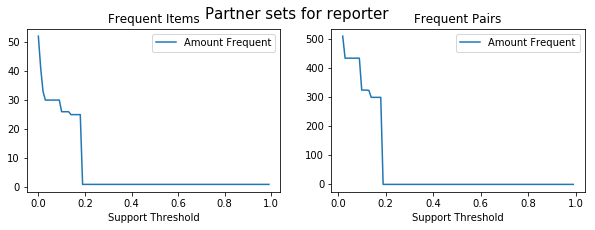

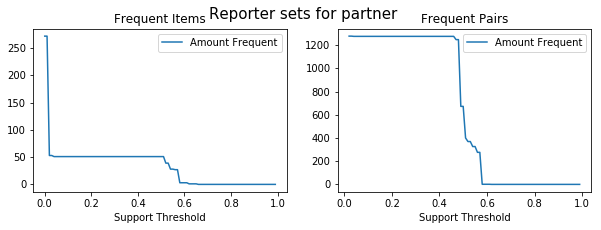

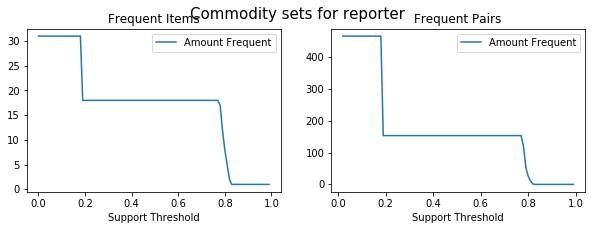

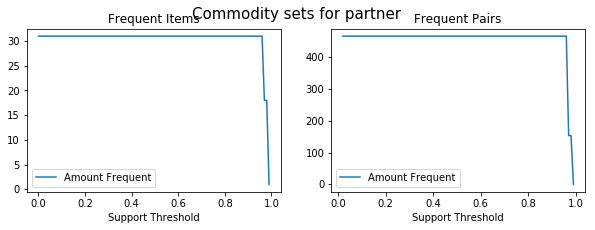

In [96]:
def frequencies_accross_thresholds(itemset, num_items):
    frequent = True
    amnt_frequent  = []
    for i in range(0,100):
        i = i / 100
        frequent_itemsets = find_frequent_itemsets(itemset, itemset, i, num_items, frequent)
        amnt_frequent.append([i, len(frequent_itemsets)])
    frequencies = pd.DataFrame(amnt_frequent, columns=['Support Threshold', 'Amount Frequent'])
    return frequencies


def plot_frequencies(itemset, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    frequencies = frequencies_accross_thresholds(itemset, 1)
    frequencies.plot(x='Support Threshold', y='Amount Frequent', ax=axes[0], title="Frequent Items");

    frequencies = frequencies_accross_thresholds(itemset, 2)
    frequencies[2:].plot(x='Support Threshold', y='Amount Frequent', ax=axes[1], title="Frequent Pairs");
    plt.suptitle(title, fontsize=15)

itemsets_p_r = create_itemsets_specify_partner(False, df_exports, ['Partner_description', 'Reporter_description'])
plot_frequencies(itemsets_r_p, "Partner sets for reporter")

itemsets_r_p = create_itemsets_specify_partner(False, df_exports, ['Reporter_description', 'Partner_description'])
plot_frequencies(itemsets_p_r, "Reporter sets for partner")

itemsets_r_i = create_itemsets_specify_partner(False, df_exports, ['Reporter_description', 'Indicator_description'])
plot_frequencies(itemsets_r_i, "Commodity sets for reporter")

itemsets_p_i = create_itemsets_specify_partner(False, df_exports, ['Partner_description', 'Indicator_description'])
plot_frequencies(itemsets_p_i, "Commodity sets for partner")

In [ ]:
frequent = True
rules = find_association_rules(items_dict, 0.6, 1, frequent)

##### Summary

What the graphs for similarity tell us is that reporters and partners are often different, but the type of good traded is always more similar...
Further anaylis showed ...... disimilar items..... association rules ..... 

Summarize some interesting things we found and some other scenarios where this may be useful, ex. you are interesed in the properties of specific commodities...

In [259]:
rules = find_association_rules(itemsets_p_r, 0.6, 1, True)
print(rules)

[(['United States of America'], 'Mexico', 1.0), (['Mexico'], 'United States of America', 0.9411764705882353)]


# Counting Triangles

After plotting all the values seen above, and unstacking the plot according to category we can see that all the categories are identical in terms of number of triangles. For ease of viewing we not separate based on category.

In [ ]:
# fetch data
triangles_df = pd.read_csv('./output-data/triangles.csv')
traingles_no_category = triangles_df[triangles_df['category'] == 'All']


# create plot
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
grouped_triangles = traingles_no_category.groupby(['year']).sum()
grouped_triangles['num_triangles'].plot(ax=axes[0], title='num triangles');
grouped_triangles['num_nodes'].plot(ax=axes[1], title='num vertices');
grouped_triangles['num_edges'].plot(ax=axes[2], title='num edges');
plt.suptitle("Plot triangle count with no category specified", fontsize=20);
plt.show()

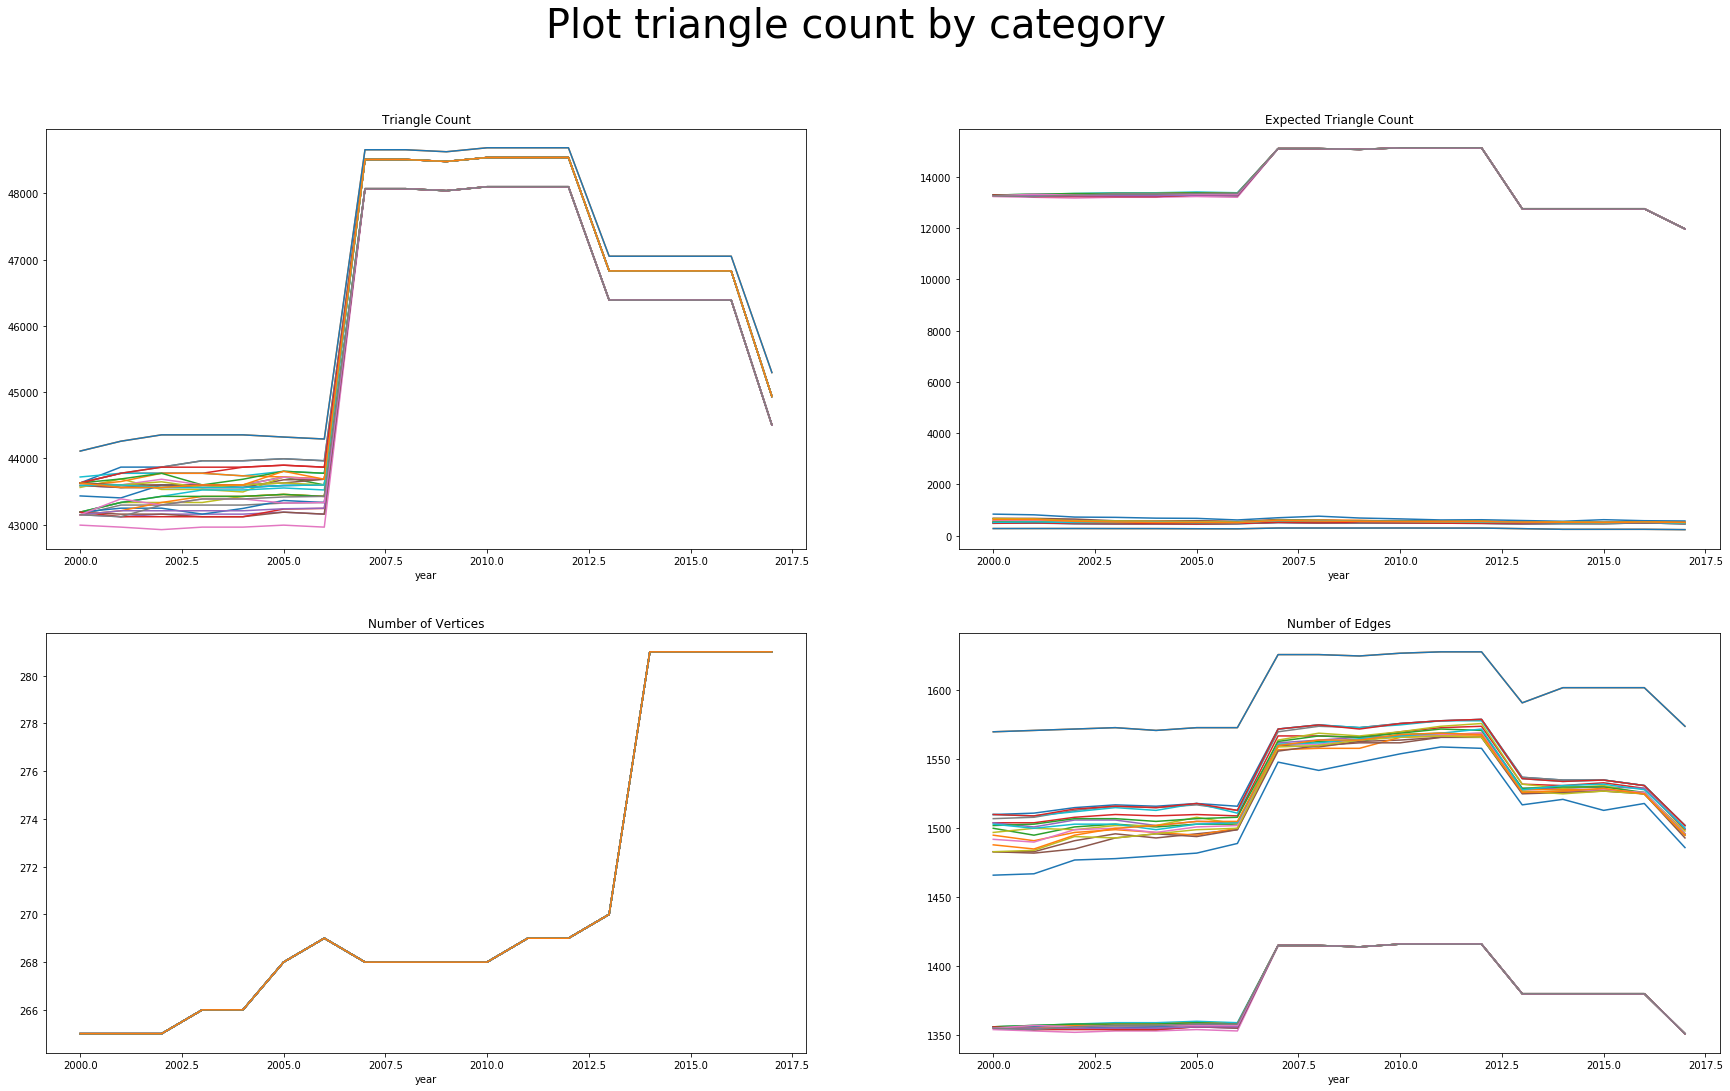

In [167]:
# fetch data
triangles_df = pd.read_csv('./output-data/triangles.csv')

# create plot
fig, axes = plt.subplots(2, 2, figsize=(30, 17))
grouped_triangles = triangles_df.groupby(['year', 'category']).sum()
grouped_triangles['num_triangles'].unstack().plot(
     ax=axes[0, 0], legend=False, title='Triangle Count')
grouped_triangles['expected_triangles'].unstack().plot(
    ax=axes[0, 1], legend=False, title='Expected Triangle Count')
grouped_triangles['num_nodes'].unstack().plot(
    ax=axes[1, 0], legend=False, title='Number of Vertices')
grouped_triangles['num_edges'].unstack().plot(
    ax=axes[1, 1], legend=False, title='Number of Edges');

plt.suptitle("Plot triangle count by category", fontsize=40);
plt.show()

# Correlation between page rank and value

In [ ]:
# TODO

# Comparison between calculated values

In [27]:
# Import data
df = pd.read_csv('./data/merchandise_values_page_ranks_weighted_unweighted.csv')
df = df[df['Year'] > 2000]
# df = df.groupby(['Reporter_description', 'Indicator_description']).median()
df_largest = df.nlargest(20, 'Weighted_PageRank')
df_largest

,Unnamed: 0,Reporter_code,Reporter_description,Partner_code,Partner_description,Indicator_code,Indicator_description,Flow_Code,Flow_Description,Year,Unit,Value,Flag,Source_Description,Note,Weighted_PageRank,Unweighted_PageRank
299140,299140,DGA,Developing Asia,RU,Russian Federation,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,226.758387,,WTO,,0.34991,0.045185
299141,299141,DGA,Developing Asia,OAS,Other Asia,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,63687.786422,,WTO,,0.34991,0.045185
299142,299142,DGA,Developing Asia,US,United States of America,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,19987.717450,,WTO,,0.34991,0.045185
299143,299143,DGA,Developing Asia,ZA,South Africa,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,127.644663,,WTO,,0.34991,0.045185
299144,299144,DGA,Developing Asia,JP,Japan,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,25026.934447,,WTO,,0.34991,0.045185
299145,299145,DGA,Developing Asia,IN,India,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,6350.341579,,WTO,,0.34991,0.045185
299146,299146,DGA,Developing Asia,WL,World,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,463635.136612,,WTO,,0.34991,0.045185
299147,299147,DGA,Developing Asia,NAX,North America,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,23503.547668,,WTO,,0.34991,0.045185
299148,299148,DGA,Developing Asia,ANZ,Australia and New Zealand,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,1794.092285,,WTO,,0.34991,0.045185
299149,299149,DGA,Developing Asia,AFR,Africa,MAMTOTIC,Integrated circuits and electronic components,X,Exports,2017,million USD,801.245088,,WTO,,0.34991,0.045185


#### Similarity matrices

In [278]:
# Plot Similarity Matrix
def create_similarity_matrix(nodes, itemsets_r_p):
    sims = {}
#     for node in nodes:
        
    
# CODE FOR THIS IS IN THE ASSOCIATION RULE MINING SECTION
# WRONG!!! NEED TO CREATE ITEMSET DICTS THEN USE JACCARD SIMILARITIES.....
# DISTANCES OF PAGE RANKS....
# itemsets_r_p = create_itemsets_specify_partner(False, df_exports, ['Reporter_description', 'Partner_description'])
# itemsets_r_p

# TODO COULD CREATE THESE DICTS WITH REPORTER_DESCRIPTION, PARTNER_DESCRIPTOIN, INDICATOR_DESCIPTION

# plot_similarity_matrix(list(df_largest.index))

In [ ]:
# TODO plot degree vs page rank

In [270]:
exports_page_rank_df.Weighted_PageRank.value_counts()

0.000000    295512
0.024943        33
0.003092        33
0.039983        33
0.004927        33
0.002849        33
0.005398        33
0.007397        33
0.031477        33
0.005202        33
0.027593        33
0.004903        33
0.037505        33
0.126626        33
0.141541        33
0.146084        33
0.007442        33
0.143678        33
0.034313        33
0.124580        33
0.009521        33
0.003216        33
0.135087        33
0.112647        33
0.018909        33
0.138729        33
0.134856        33
0.001299        33
0.007174        33
0.039020        33
             ...  
0.002957         2
0.000380         2
0.000682         2
0.002138         2
0.002877         2
0.000318         2
0.000769         2
0.001583         2
0.000876         2
0.000984         2
0.000906         2
0.019400         2
0.002468         2
0.001077         2
0.001367         2
0.004519         2
0.004478         2
0.001668         2
0.001915         2
0.001413         2
0.001607         2
0.001343    

In [271]:
df = pd.read_csv('./data/merchandise_values_page_ranks_weighted_unweighted.csv')
df = df[df['Reporter_description'] == 'World']
df.Indicator_description.value_counts()

Total merchandise    140
Name: Indicator_description, dtype: int64

# Make Files for Similarity Test

In [ ]:
x = data_exports.groupby(['Reporter_description', 'Indicator_description']).sum()
similar_reporters, dissimilar_reporters, identical_reporters = create_sims_dict(x)
# identical_reporters = sims[1]
# print("Reporters that are identical in type of goods traded", len(identical_reporters), "\nTotal reporters", len(x.index.levels[0]))

identical_reporters_formatted = []

# remove last tuple element so it works with itemsets code
for x, i, y in identical_reporters:
    identical_reporters_formatted.append((x, i))

ident = create_itemsets(identical_reporters_formatted)
ident['World']

In [ ]:
x = data_exports.groupby(['Reporter_description', 'Indicator_description']).sum()
# data_exports[['Reporter_description', 'Indicator_description']].to_dict()
x.index.levels[0]
list(x.index)
items_dict = {}
for reporter, item in x.index:
    items_list = items_dict.get(reporter)
    if items_list is None:
        items_dict[reporter] = [item]
    else:
        items_list.append(item)
        items_dict[reporter] = items_list
        
items_dict

# DEGREE 

In [ ]:
# TODO

# Visualization

## Counts through time

In [ ]:
def pie_with_legend(data_2, upp_leg=1.3):
    fig = plt.figure()
    ax = plt.subplot(111)
    plot = data_2.plot.pie(y='Value', figsize=(15, 15), ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, upp_leg),
              ncol=3, fancybox=True, shadow=True)

def fun_plots(data):
    grouped_by_year = data.groupby('Year').sum()
    grouped_by_year.plot(figsize=(15,7));

    grouped_by_year_merch = data.groupby(['Year', 'Indicator_description']).sum()
    grouped_by_year_merch['Value'].unstack().plot(figsize=(20,10))

    merch_totals = data.groupby('Indicator_description').sum()
    pie_with_legend(merch_totals)
    
    
fun_plots(data_exports)

In [ ]:
data_remove_total_merch = data_exports[data_exports['Indicator_description'] != 'Total merchandise']
fun_plots(data_remove_total_merch)

## Zoom in on total manufactures

In [ ]:
manufactures = data_exports[data_exports["Indicator_description"] == 'Manufactures']
manufactures_exporter = data_exports.groupby(['Reporter_description']).sum()
manufactures_importer = data_exports.groupby(['Partner_description']).sum()
# manufactures_exporter.drop(columns=['Year'])

In [ ]:
pie_with_legend(manufactures_exporter, 3)

In [ ]:
pie_with_legend(manufactures_importer, 1.5)

## Full data look at exporters and importers

In [ ]:
grouped_by_year_importer = data_exports.groupby(['Year', 'Partner_description']).sum()
grouped_by_year_importer['Value'].unstack().plot(figsize=(20,20))

In [ ]:
data_2000 = data_exports[data_exports['Year'] < 2000]
data_2000['Partner_description'].value_counts()

In [ ]:
grouped_by_year_exporter = data_exports.groupby(['Year', 'Reporter_description']).sum()
grouped_by_year_exporter['Value'].unstack().plot(figsize=(20,20))

In [ ]:
data_2000 = data_exports[data_exports['Year'] < 1970]
len(data_2000['Reporter_description'].value_counts())

In [ ]:
data_agg_by_year = data_exports.groupby(['Year']).nunique()
data_agg_by_year = data_agg_by_year.drop(columns=['Value', 'Note', 'Flow_Code', 'Flow_Description', 'Partner_code', 'Indicator_code'])
data_agg_by_year.plot(figsize=(20,20));

In [ ]:
data_exports[data_exports['Year'] == 1948].head()

In [ ]:
data_agg_by_year = data_exports.groupby(['Year', 'Reporter_description']).nunique()

## Visualize Pageranks

In [ ]:
data_exports_with_page_rank = pd.read_csv('./data/merchandise_values_added_page_ranks.csv')

### First try just with specific countries over specific merchandise

In [ ]:
grouped = data_exports_pr.groupby('Reporter_description').mean()
grouped.PageRank

In [ ]:
def plot_page_ranks_values(country):
    country_exports = data_exports_with_page_rank[data_exports_with_page_rank['Reporter_description'] == country]
    country_exports['Indicator_description'].value_counts()
    country_exports = country_exports.groupby(['Year', 'Indicator_description']).sum()
    # grouped_by_year_exporter = data_exports.groupby(['Year', 'Reporter_description']).sum()
    country_exports['Value'].unstack().plot(figsize=(20,10), title=country)
    country_exports['PageRank'].unstack().plot(figsize=(20,10))
    
plot_page_ranks_values('Africa')
plot_page_ranks_values('North America')
plot_page_ranks_values('Developing Asia')

In [ ]:
electronics = data_exports_with_page_rank[data_exports_with_page_rank['Indicator_description'] == 'Integrated circuits and electronic components']
# electronics_grouped = electronics.groupby(['Year', 'Reporter_description']).sum()
# electronics_grouped['Value'].unstack().plot(figsize=(20,10))
# electronics_grouped['PageRank'].unstack().plot(figsize=(20,10))

electronics_grouped = electronics.groupby('Reporter_description').sum()
electronics_grouped.plot.pie(y='PageRank')

In [ ]:
## THIS WAS DONE BEFORE CREATING PAGERANK CSV
page_rank_dir = './output-data/page_ranks/by_year/weighted/'
manufactors_page_ranks = sorted(glob.glob(page_rank_dir + '*-Manufactures.tsv'))

for m in manufactors_page_ranks:
    df = pd.read_csv(m, sep='\t')
    fig = plt.figure()
    ax = plt.subplot(111)

    plot = df.plot.pie(y='PageRank', labels=df['Ids'], figsize=(15, 15), ax=ax)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
              ncol=3, fancybox=True, shadow=True)